# Expected Threat (xT) 

## Introduction

Welcome to this toturial, where we delve into the exciting world of Expected Threat (xT) metrics in the context of football (soccer) analytics. The concept of Expected Threat, popularized by Karun Singh and others, provides a powerful framework for quantifying the potential threat posed by a team or player in different regions of the field.

Expected Threat is a statistical metric that assigns a numerical value to each location on the pitch, reflecting the likelihood of a goal being scored in the same possession based on historical data. This metric is helpfull for gaining insights into team strategies, player performance, and overall match dynamics.

The notebook is a showcase of how the xT in the `databallpy` package is calculated. However, it is closely based on the work and blog of Karun Singh (see the article [here](https://karun.in/blog/expected-threat.html))

## What to Expect

1. **Data Loading:** We will start by loading football event data into our Jupyter environment. The dataset will serve as the foundation for our xT calculations. Note that the data is not publicaly available.

2. **xT Calculation:** We will dive into the mathematical foundations of Expected Threat, discussing how to compute xT values for various events on the field. You'll gain insights into the factors influencing threat levels and how to model them effectively.

3. **Visualization:** Effective visualization is key to understanding and communicating xT metrics. We'll explore different plotting techniques to represent xT values spatially on the football pitch.

```{warning}
Although we try to keep everything up to date, the code in this notebook might not perfectly align with the code in the package. If you find any bugs or have any suggestions, please let us know.
```

## Preprocessing the Data

The data contains event data of over 600 matches. For every on-ball event (pass, shot, or dribble) we indicate whether it was successful, what the start location was of the event, and for passes and dribbles, what the end location of the event was if the event was successful. Note that all events are normalised so that the goal is to score on the right side of the pitch.

```{note}
This is a private dataset and is not available for public use, the final model however is available in the `databallpy` package.
```

Preprocessing consists of the following steps:

1. Load the data

2. Deleting all own goals

3. Deleting all shots from the own half, they are probaly event data errors.

4. Removal of all events that happen in a set piece situation (corners, free kicks, throw-ins, goal kicks) as they are probably not representative of the general flow of play. We will use this data later to create seperate xT models for set pieces.

In [14]:
import pandas as pd

df = pd.read_pickle("../../notebooks/data/positions_goals_dataset2.pkl") 

In [15]:
import pandas as pd
from databallpy.visualize import plot_soccer_pitch
from databallpy.features.angle import get_smallest_angle
import matplotlib.pyplot as plt
import numpy as np
import json
from databallpy.models.utils import scale_and_predict_logreg

# Read in your data as df here
# df = pd.read_csv('data.csv')

df = df[df["event"]!="own_goal"]
df = df[~((df["event"]=="shot") & (df["successful"]==1) & (df["start_x"] < 0))]
df = df[df["set_piece"]=="no_set_piece"]
print(df.columns)
print(df[["start_x", "start_y", "end_x", "end_y", "successful", "n_events_next_goal"]].info())

Index(['match_id', 'possession_id', 'datetime', 'team_id', 'start_x',
       'start_y', 'end_x', 'end_y', 'event', 'successful', 'set_piece',
       'n_seconds_next_goal', 'n_events_next_goal'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 572116 entries, 1 to 630745
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   start_x             572116 non-null  float64
 1   start_y             572116 non-null  float64
 2   end_x               442035 non-null  float64
 3   end_y               442035 non-null  float64
 4   successful          572116 non-null  int64  
 5   n_events_next_goal  293274 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 30.6 MB
None


`end_x` and `end_y` are only defined when the event was successful. For example, a pass that was intercepted will not have an `end_x` and `end_y` value. On top of that, the `n_events_next_goal` will be `np.nan` if there is no goal scored in the remainder of the match for that team.

## Define Constants

Now we will define the constants for the grid over the pitch, and the size of the pitch

In [16]:
N_X_BINS = 32
N_Y_BINS = 24
X_RANGE = (-53, 53)
Y_RANGE = (-34, 34)
PITCH_LENGTH = 106
PITCH_WIDTH = 68
CELL_LENGTH = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
CELL_WIDTH = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

## Visualisations of Dataset

Now it's important to check what are data actually looks like. In the next part we will look at the success rate of all actions, shots, and where on the pitch these actions happen.

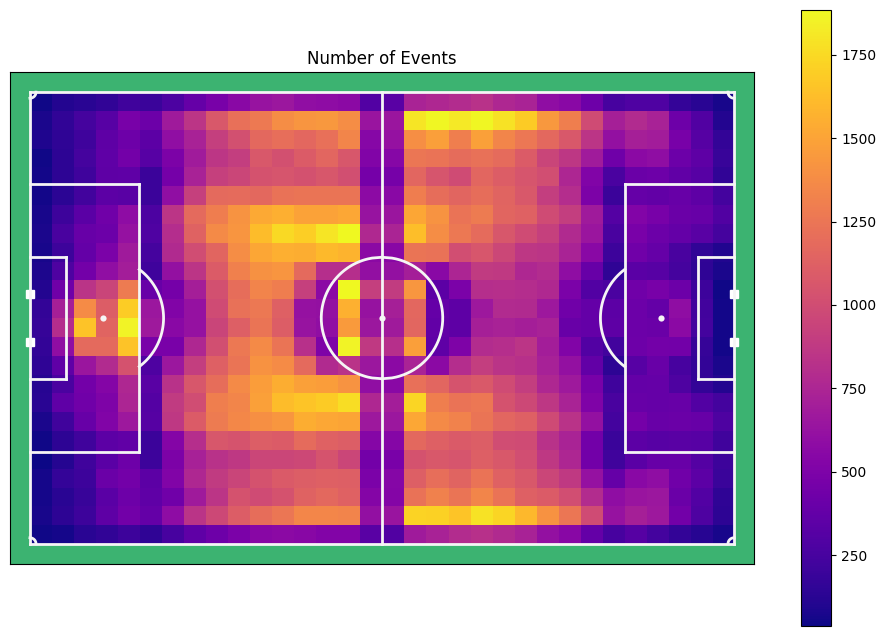

In [21]:
def calculate_histogram2d(df, condition, start_x='start_x', start_y='start_y', hist2d_params=None):
    """
    Calculate a 2D histogram for given conditions.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        condition (pd.Series): Boolean Series to filter the DataFrame.
        start_x (str): Column name for x values.
        start_y (str): Column name for y values.
        hist2d_params (dict): Parameters for np.histogram2d.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: The histogram, x edges and y edges.
    """
    filtered_df = df.loc[condition, [start_x, start_y]]
    hist, x_edges, y_edges = np.histogram2d(filtered_df[start_x], filtered_df[start_y], **hist2d_params)
    return hist, x_edges, y_edges

hist2d_params = {"bins": (N_X_BINS, N_Y_BINS), "range": [X_RANGE, Y_RANGE]}

hist_events, x_edges, y_edges = calculate_histogram2d(df, pd.Series([True] * len(df), df.index), hist2d_params=hist2d_params)
hist_shots, _, _ = calculate_histogram2d(df, df["event"] == "shot", hist2d_params=hist2d_params)
hist_goals, _, _ = calculate_histogram2d(df, (df["event"] == "shot") & (df["successful"] == 1), hist2d_params=hist2d_params)
hist_ball_moves, _, _ = calculate_histogram2d(df, df["event"] != "shot", hist2d_params=hist2d_params)
hist_ball_moves_succ, _, _ = calculate_histogram2d(df, (df["event"] != "shot") & (df["successful"] == 1), hist2d_params=hist2d_params)

ratio_shots = np.divide(hist_shots, hist_events, where=hist_events != 0)
ratio_goals = np.divide(hist_goals, hist_shots, where=hist_shots != 0)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events != 0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves != 0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

def plot_results(data, title=None, label=None, add_text=True, add_cbar=True, n_x_bins_func=N_X_BINS, n_y_bins_func=N_Y_BINS):
    """Function to plot a grid over a pitch. Assumes that the values are ratio's and
    will be transformed to percentages. 

    Args:
        data (np.ndarray): The ravelled grid over the pitch
        title (str, optional): The title of the plot. Defaults to None.
        label (str, optional): The label of the colorbar. Defaults to None.
        add_text (bool, optional): Whether to print the percentages in the plot.
            Defaults to True.
        add_cbar (bool, optional): Whether to plot the colorbar. Defaults to True.
        n_x_bins_func (int, optional): The number of cells in the length of the pitch. 
            Defaults to N_X_BINS.
        n_y_bins_func (int, optional): The number of cells in the widht of the pitch. 
            Defaults to N_Y_BINS.
    """

    fig, ax = plot_soccer_pitch()
    im = ax.imshow(data.reshape(n_x_bins_func, n_y_bins_func).T * 100, cmap="plasma", extent=[-53., 53, 34., -34], zorder=-100)
    if add_cbar:
        plt.colorbar(im, ax=ax, label=label)
    ax.set_title(title)
    
    if add_text:
        cell_length_func = PITCH_LENGTH /n_x_bins_func 
        cell_width_func = PITCH_WIDTH / n_y_bins_func
        for idx in range(len(data)):
            x1 = X_RANGE[0] + (idx // n_y_bins_func) * cell_length_func
            y1 = Y_RANGE[0] + (idx % n_y_bins_func) * cell_width_func
            ax.text(x=x1+cell_length_func/2, y=y1+cell_width_func/2, s=f"{round(data[idx] *100)}", fontsize=7, alpha=0.8, color='black', ha='center', va='center')
    plt.show()


titles = [
    "Number of Events", 
    "Percentage Shots of all Events", 
    "Percentage Goals of all Shots", 
    "Percentage Ball Moves of all Events", 
    "Percentage Successful Moves of all Ball Moves"
]
ratios = [hist_events, ratio_shots, ratio_goals, ratio_ball_moves, ratio_ball_moves_succ]
plot_results(hist_events.ravel()/100., title=titles[0], add_text=False, )

This plot shows for every cell in the grid, the number of events that are happening there. Interestingly, you can see that around the middle line and the circle, less events occur. This has probably to do with a bias in the event data software to place an event in a specified part of the pitch. For now we can not do much about that. Note that we excluded set piece from this plot for now, but we can also make one with set pieces of course.

Let's have a look at how the different types of events, and their success rate, are divided over the pitch.

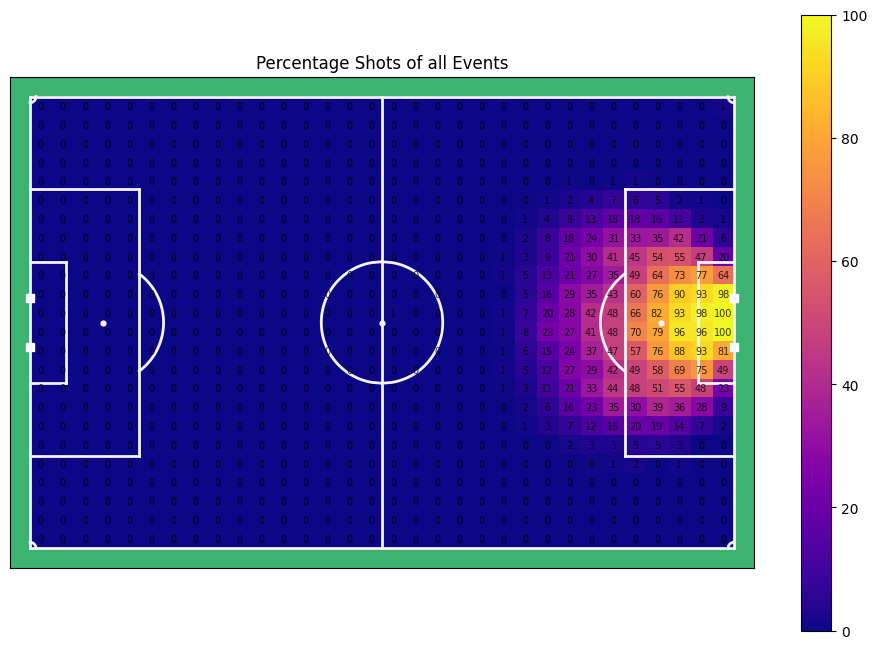

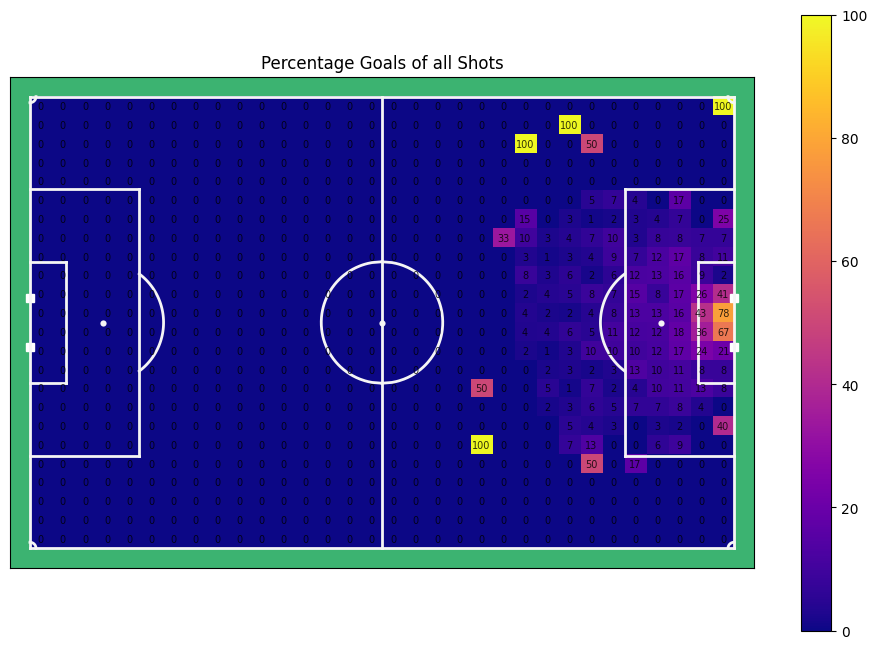

In [19]:
for title, data in zip(titles[1:3], ratios[1:3]):
    plot_results(data.ravel(), title=title, add_text=True)

As expected, shots are mainly taken from the around the box, with a bias towards the centre of the pitch. Some of the shots from far away went in, providing a 100% score for certain cells, but it is likely that this was a very specific case, not very representative for normal events.

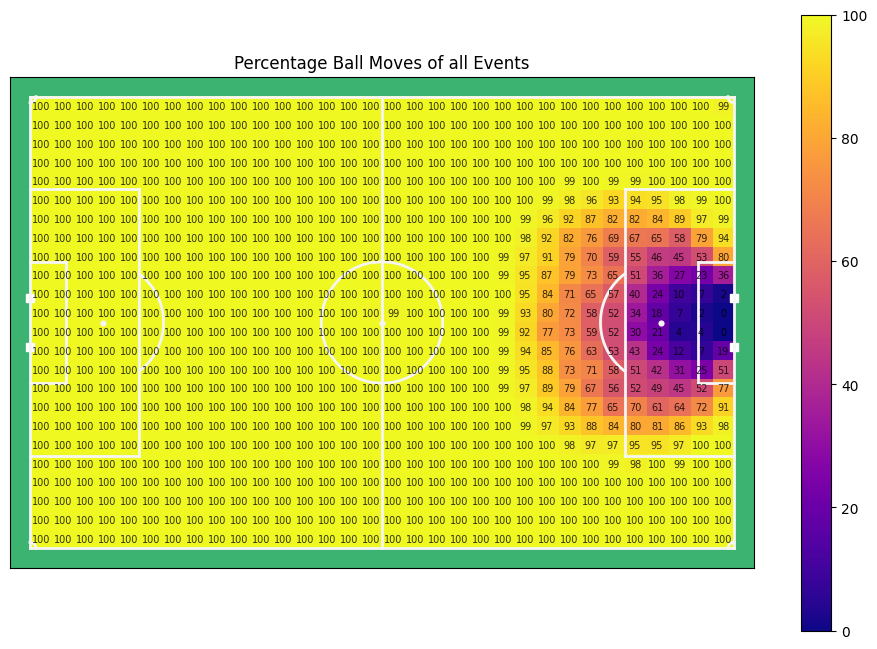

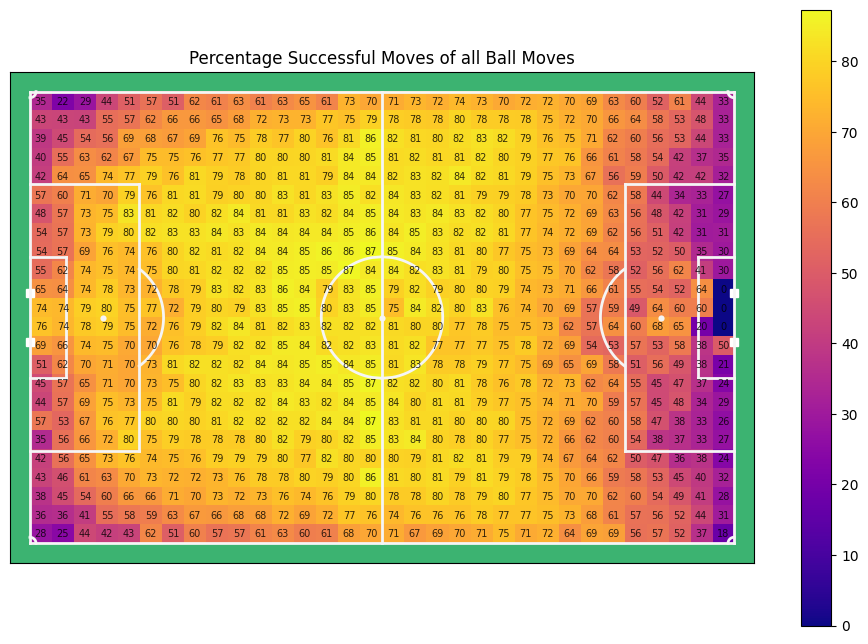

In [20]:
for title, data in zip(titles[3:], ratios[3:]):
    plot_results(data.ravel(), title=title, add_text=True)

The percentage of ball moves over all events is, of course, the inverse of the percentage of shots over all events. In general wee see a sucess rate of actions of about 80%, with higher values on ones own half, and lower values near either backline. Especially the lower success rate at ones own back line is interesting. It is likely that teams primarily get in possession there when they are highly pressured or just captured the ball and blindly shoot the ball forward (clearance) which might somethimes be labelled as a failed pass by event data providers.

## xT Defined

Expected Threat is a very intuitive idea. It basically takes the probability of shooting from a given location and multiplies it with the expected goals value, and adds the probability of moving the ball to any other location of the pitch and multiplies that times the expected threat value of that location. In a formula it looks something like this:

$ xT(x, y) = P_{shot}(x, y) * xG(x, y) + \sum \limits _{z=1} ^{x\_cells} \sum \limits _{w=1} ^{y\_cells} P_{move}(x, y -> z, w) * xT(z, w) $

Which can be simplified to:

$ xT(x, y) = P_{shot}(x, y) * xG(x, y) + P_{move} * T_{moves}(x, y) * xT $

Where $ P_{shot} $ and $ P_{move} $ are the probability of a shot and the probability of a successful ball move (pass or dribble) respectively, $ xG $ is the expected goals model and $ T_{moves}(x, y) $ is, given that a move is successfull from the current position, the likelyhood of where the ball will go next.

## Creating the Transition Matrices

Now we need for every cell in the grid a transition matrix. The transition matrix holds the ratios of where a successful pass is likely to go. We ravel the grid to get an squared 2d array of N_X_BINS * N_Y_BINS by N_X_BINS * N_Y_BINS. In this loop we also fill an xG matrix, with the xG value for every cell. After calculation we can plot the transition matrix for any given cell to get a feel of what it means.

```{note}
See the toturial of the expected goals to find how we came to the xG values.
```

In [23]:
xg_params = json.load(open("../../databallpy/models/xg_params.json"))

In [24]:
# get your own xg params or use the one in databallpy in models/xg_params.json
def get_xG(loc: np.ndarray, xg_params: dict=xg_params) -> float:
    """
    Calculate the expected goal (xG) value for a given location.

    Args:
        loc (np.ndarray): The location on the pitch as a numpy array [x, y].
        xg_params (Dict[str]): The parameters for the xG model.

    Returns:
        float: The xG value.
    """
    goal_distance = np.sqrt(np.power(X_RANGE[1] - loc[0], 2) + np.power(loc[1], 2))
    shot_angle = get_smallest_angle(loc - np.array([X_RANGE[1], 3.63]), loc - np.array([X_RANGE[1], -3.66]), angle_format="degree")
    return scale_and_predict_logreg(np.array([[goal_distance, shot_angle]]), xg_params["xG_by_foot"])[0]

def calculate_success_move_probabilities(df: pd.DataFrame, x_start: float, x_end: float, y_start: float, y_end: float, params: dict=hist2d_params) -> np.ndarray:
    """
    Calculate the success move probabilities for events within a specified cell on the pitch.

    This function filters events based on their starting position, checks if the move was successful,
    and calculates the success probability for moving the ball into different areas of the pitch from the specified cell.

    Args:
        df: A pandas DataFrame containing event data.
        x_start: The starting x-coordinate of the cell.
        x_end: The ending x-coordinate of the cell.
        y_start: The starting y-coordinate of the cell.
        y_end: The ending y-coordinate of the cell.
        params: Parameters for the numpy histogram2d function.

    Returns:
        A flattened numpy array containing the success move probabilities for the specified cell.
    """
    filtered_df = df[(df["start_x"] >= x_start) & (df["start_x"] <= x_end) & 
                     (df["start_y"] >= y_start) & (df["start_y"] <= y_end)]
    
    succ_mask = (
        (~filtered_df["end_x"].isnull()) & 
        (~filtered_df["end_y"].isnull()) & 
        (filtered_df["event"] != "shot") & 
        (filtered_df["successful"] == 1)
    )
    
    hist_ball_moves_succ, _, _ = np.histogram2d(
        filtered_df.loc[succ_mask, "end_x"], 
        filtered_df.loc[succ_mask, "end_y"], 
        **params
    )
    
    current_ratio = hist_ball_moves_succ / len(filtered_df) if len(filtered_df) > 0 else np.zeros_like(hist_ball_moves_succ)
    
    return current_ratio.ravel()

# Initialize empty grids
succ_move_probs = np.zeros((N_X_BINS * N_Y_BINS, N_X_BINS * N_Y_BINS))
xg_vals = np.zeros(N_X_BINS * N_Y_BINS)

cell_id = 0
for x_start, x_end in zip(x_edges[:-1], x_edges[1:]):
    for y_start, y_end in zip(y_edges[:-1], y_edges[1:]):        
        # Calculate the success move probabilities for the current cell
        succ_move_probs[cell_id] = calculate_success_move_probabilities(df, x_start, x_end, y_start, y_end, hist2d_params)

        # Calculate the expected goal value for the current cell
        mean_loc = np.array([np.mean([x_start, x_end]), np.mean([y_start, y_end])])
        xg_vals[cell_id] = get_xG(mean_loc)

        cell_id += 1        

In [25]:
def get_mirrored_index(index, n_rows=N_X_BINS, n_cols=N_Y_BINS):
    x_idx = index // n_cols
    x_mean_idx = (n_rows-1) / 2 
    x_diff = np.abs(x_mean_idx - x_idx)
    if x_idx > x_mean_idx:
        x_idx -= (2*x_diff) 
    else:
        x_idx += (2*x_diff) 

    y_idx = index % n_cols
    y_mean_idx = (n_cols-1) / 2 
    y_diff = np.abs(y_mean_idx - y_idx)
    if y_idx > y_mean_idx:
        y_idx -= (2*y_diff) 
    else:
        y_idx += (2*y_diff) 

    return int(x_idx*n_cols + y_idx)

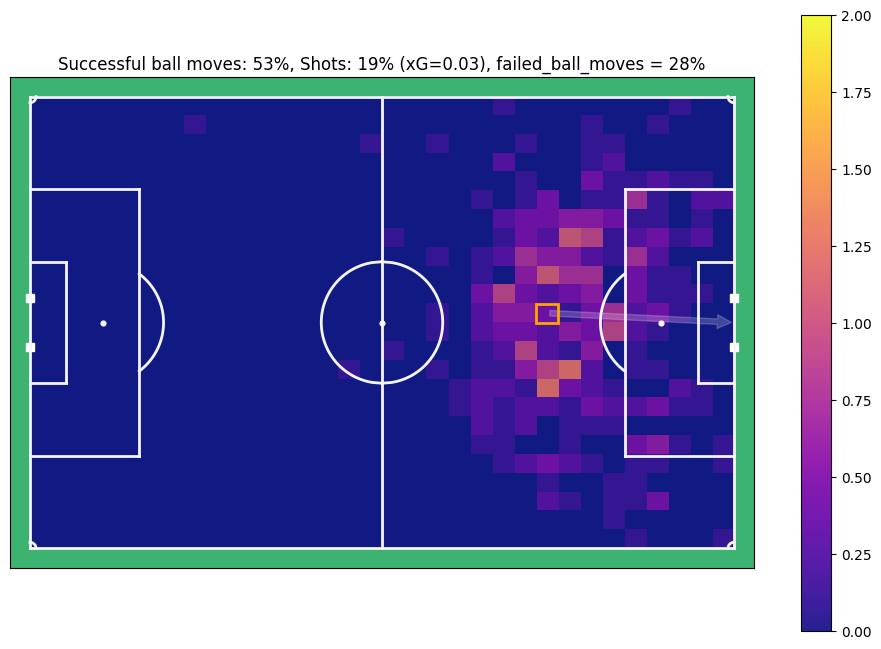

In [26]:
# If you have your own dataset, you can run this notebook and click on the pitch to see the success move probabilities
# %matplotlib widget

import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import numpy as np

def setup_plot():
    plt.close("all")
    fig, ax = plot_soccer_pitch()
    return fig, ax

def calculate_cell_position(idx: int) -> tuple[float, float]:
    box_width = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
    box_height = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS
    x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
    y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height
    return x1, y1, box_width, box_height

def plot_initial_state(ax, idx: int):
    x1, y1, box_width, box_height = calculate_cell_position(idx)
    ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
    img = ax.imshow(ratio.T*100, cmap="plasma", alpha=0.9, vmin=0.0, vmax=2.0, extent=[-53., 53, 34., -34], zorder=-100)
    fig.colorbar(img)

    goal_loc = (53.0, 0)
    arrow = mpatches.FancyArrowPatch((x1 + 0.5 * box_width, y1 + 0.5 * box_height), goal_loc, mutation_scale=20, alpha=ratio_shots.ravel()[idx], color="white")
    ax.add_patch(arrow)

    update_plot_title(ax, idx, ratio)

    rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
    ax.add_patch(rec)

def update_plot_title(ax, idx: int, ratio: np.ndarray):
    ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
    ratio_shot = int(ratio_shots.ravel()[idx] * 100)
    xg = round(xg_vals[idx], 2)
    ratio_failed_ball_move = 100 - ratio_suc_ball_move_per - ratio_shot
    ax.set_title(f"Successful ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")

def on_click(event):
    if event.inaxes == ax:
        clear_plot(ax)
        idx, ratio = handle_click_event(event)
        update_plot_title(ax, idx, ratio)
        fig.canvas.draw_idle()

def clear_plot(ax):
    [col.remove() for col in ax.collections]
    [patch.remove() for patch in ax.patches]
    [text.remove() for text in ax.texts]
    [im.remove() for im in ax.images]

def handle_click_event(event) -> tuple[int, np.ndarray]:
    pitch_size = (X_RANGE[1] - X_RANGE[0], Y_RANGE[1] - Y_RANGE[0])
    x_idx = np.floor((event.xdata + X_RANGE[1]) / (pitch_size[0] / N_X_BINS))
    y_idx = np.floor((event.ydata + Y_RANGE[1]) / (pitch_size[1] / N_Y_BINS))
    idx = int(x_idx * N_Y_BINS + y_idx)
    ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
    plot_click_state(ax, idx, event.xdata, event.ydata, ratio)
    return idx, ratio

def plot_click_state(ax, idx: int, x: float, y: float, ratio: np.ndarray):
    img = ax.imshow(ratio.T*100, cmap="plasma", alpha=0.9, vmin=0.0, vmax=2.0, extent=[-53., 53, 34., -34], zorder=-100)
    x1, y1, box_width, box_height = calculate_cell_position(idx)
    rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
    ax.add_patch(rec)
    ax.scatter([x], [y], color="black")
    goal_loc = (53.0, 0)
    arrow = mpatches.FancyArrowPatch((x, y), goal_loc, mutation_scale=20, alpha=ratio_shots.ravel()[idx], color="white")
    ax.add_patch(arrow)

fig, ax = setup_plot()
plot_initial_state(ax, idx=int(N_Y_BINS * (N_X_BINS - int(0.3*N_X_BINS)) + (0.5 * N_Y_BINS)))
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

For this position, you can see that on average, the ball is moved successfully in 53% of cases, in 19% of cases there is a shot, of which 3% result in a goal, and 28% of tried ball moves are unscussefull.

## Creating xT

You might have noticed that in the formula, the xT of one position is dependend on the xT of all other positions. So how do you solve the equation? There is no absolute way to get to the values, but Karun Singh found out that you can solve the equation iteratively. You start by initializing all xT values on the pitch at 0. After the first iteration, all values are equal to the xG values of that position. After all, passing the ball to another location gives an xT of zero (the initialised values). However, since the values change over time due to the xG, after about 5 iterations the model converges, they don't really change values anymore and reach a stable state.

Lets have a look of how that looks in Python:

In [12]:
%matplotlib inline

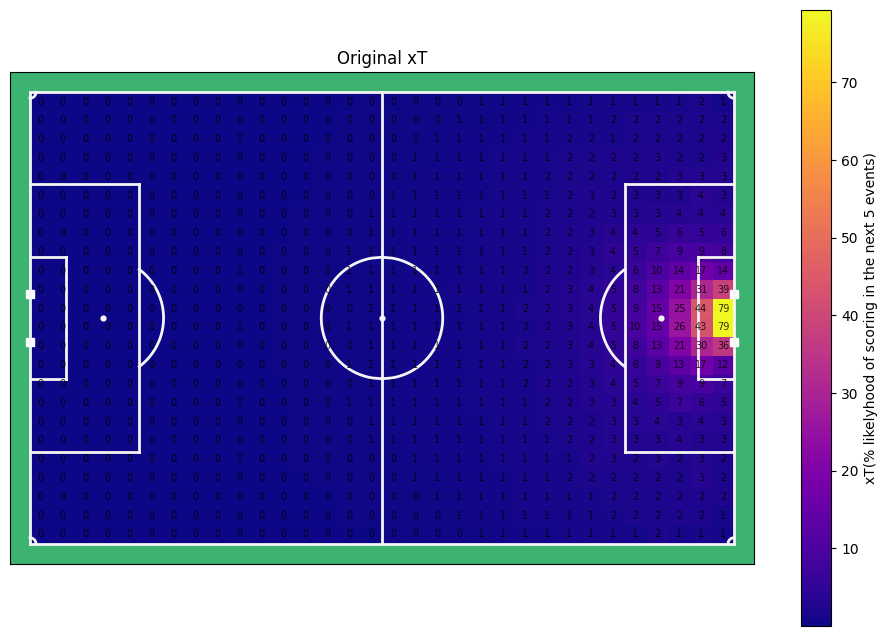

In [13]:
plt.close("all")

original_xT = np.zeros(N_X_BINS * N_Y_BINS)
next_xT = original_xT.copy()

# Iterations to converge the model
for i in range(7):

    # Loop over all possible location where you can have the ball
    for current_cell_id in range(len(original_xT)):

        # Given the current location, update the xT with the probability of a shot times the xG value of that shot
        current_cell_xT =  xg_vals[current_cell_id] * ratio_shots.ravel()[current_cell_id] 

        # Loop over all possible ball move options, and their likelyhood of happening successfully
        for to_cell_id in range(len(original_xT)):

            # Update the xT with the probability of a successful ball move times the xT of that end location
            current_cell_xT += succ_move_probs[current_cell_id, to_cell_id] * original_xT[to_cell_id]

        # Save the new xT of the current position
        next_xT[current_cell_id] = current_cell_xT

    # Update the original xT for the next iteration
    original_xT = next_xT.copy()

plot_results(original_xT, title="Original xT", label="xT(% likelyhood of scoring in the next 5 events)" )

And there it is, the xT model for open play! A few things are notably. Firstly, it looks pretty simatrical from left to right. It values positions in the centre of the pitch higher than the sides, and it values proximity to the goal higher than distant cells. I think these are very intuitive results. We can now value for every position the xT by putting them in a cell on the pitch. However, as you can see, this would mean that there is never a xt value of 0.6, since no of the cells are anywhere near 60. Lets use some interpolation to get a more finegrained prediciton of the xT.

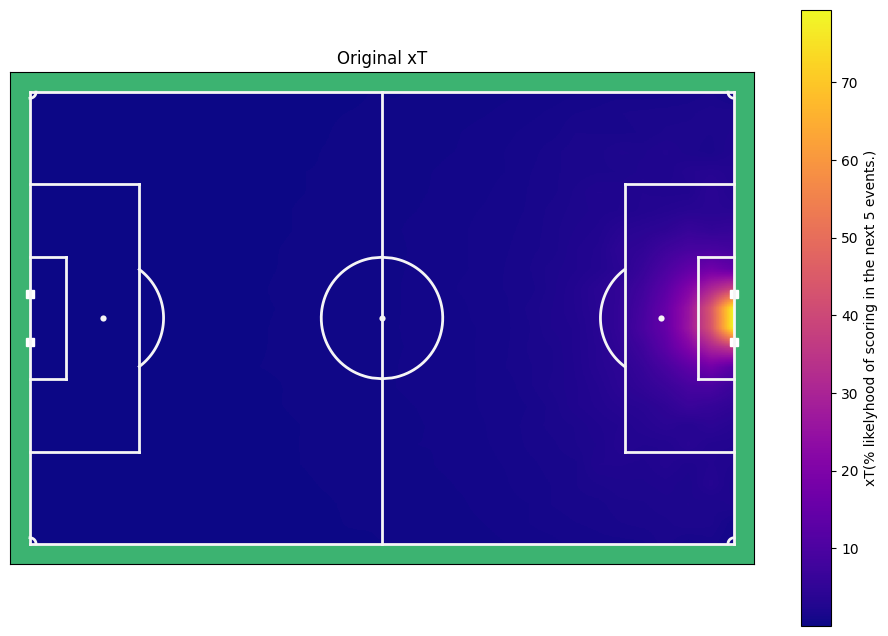

In [14]:
from scipy.ndimage import zoom

finegrained_xT = zoom(original_xT.reshape(32, 24), [264/N_X_BINS, 196/N_Y_BINS], order=1)

plot_results(finegrained_xT.ravel(), title="Original xT", label="xT(% likelyhood of scoring in the next 5 events.)", add_text=False, n_x_bins_func=264, n_y_bins_func=196)

def get_xT_prediction(x:float | np.ndarray, y:float | np.ndarray, xT_model=finegrained_xT) -> float | np.ndarray:
    """ Function to get the predicted xT based on a position and a xT model

    Args:
        x (float): x coordinate on the pitch (-53, 53).
        y (float): y coordinate on the pitch (-34, 34).
        xT_model (np.ndarray, optional): The xT model to use. Defaults to finegrained_xT.

    Returns:
        float: xT value
    """
    x_cells, y_cells = xT_model.shape

    x_idx = np.clip((x + 53) * (x_cells / 106), a_min=0, a_max=x_cells-1).astype(int)
    y_idx = np.clip((y + 34) * (y_cells / 68), a_min=0, a_max=y_cells-1).astype(int)

    return xT_model[x_idx, y_idx]   

## Evaluating the model

But to what extend does the model actually hold true to its promis to give the ratio of goals scored within the next 5 events?

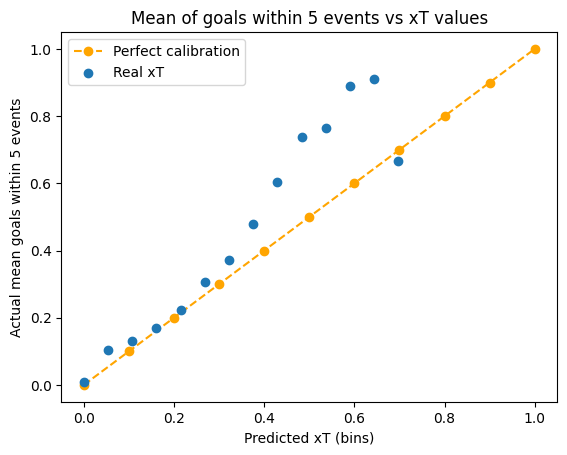

In [15]:
goal_within_5_events = (df["n_events_next_goal"] < 5).fillna(0)

x, y = df["start_x"].values, df["start_y"].values
xt_values = get_xT_prediction(x, y)

bins = np.linspace(xt_values.min(), xt_values.max(), 15)
bin_indices = np.digitize(xt_values, bins)
bin_means = [np.nanmean(np.array(goal_within_5_events)[bin_indices == i]) for i in range(1, len(bins))]
plt.close("all")
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), marker="o", label="Perfect calibration", linestyle='--', color="orange", zorder=-1)
ax.scatter(bins[:-1], bin_means, label="Real xT")
ax.set_xlabel('Predicted xT (bins)')
ax.set_ylabel('Actual mean goals within 5 events')
ax.set_title('Mean of goals within 5 events vs xT values')
ax.legend()
plt.show()

That looks pretty decent. There are of course far less events with a high xT value, so it is harder to evaluate those and noise might play a bigger role. That being said, it seems to model the probabilities almost perfect up and until 0.4, which accounts for over 99 % of all pitch locations. For the higher values, it seems to be struggling a bit, but because there are only very few instances where values higher than .5 are predicted (162 of about 600000 events (0.02%)), I think this is a very decent outcome.

Note that there are two major shortcomming with this method. Firstly, it is not capable of valuing defensive actions. The model is possession based and therefore assumes that you will keep possession of the ball. Secondly, the model only utilizes the location of the ball. This of course over simplifies the complexity of what is happening on the pitch. An example of an improvement is the model developed by Greg Everett et al (2022) who created a [contextualized xT](https://statsbomb.com/wp-content/uploads/2023/03/Gregory-Everett-et-al-Contextual-xT-using-Spatial-Event-Data.pdf).

That begin said, lets save the model to make sure anyone can use the xT model in the future!

# xT in DataBallPy

What do you have to do to get the xT model output in DataBallPy? It is actually very simple. Since the output is basically a grid, and does not require any computation we added it automatically to all `databallpy_events`! For instance, if you wish to now what the xT at the moment of a shot, simply look at the `match.shots_df`, `match.passes_df`, or the `match.dribbles_df` in the `"xT" column`. 

```{note}
The xT model in this notebook is only with open play events. In DataBallPy we have xT models for throw-ins, corners, goal kicks, kicks offs, and free kicks as well. However, the trick is the same, therefore we decided not to make this notebook unnecessarily long.
```

```python
from databallpy import get_match, get_open_match

match = get_match(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open match provided by Metrica
match = get_open_match()

print(match.passes_df["xT"])
```

```{note}
The current supported tracking data providers are:

- Tracab
- Metrica
- Inmotio

The current supported event data provider are:
- Opta
- Metrica
- Instat

If you wish to use a different provider that is not listed here, please open an issue [here](https://github.com/Alek050/databallpy/issues)
```


In [16]:
from databallpy import get_saved_match
import os

match = get_saved_match("synced_match", os.path.join("..", "saved_matches"))

print(match.passes_df["xT"].head())

0    0.001000
1    0.002746
2    0.002224
3    0.019289
4    0.000844
Name: xT, dtype: float64


# Conclusion

In this tutorial, we explored the concept of Expected Threat (xT) in football analytics. We discussed the mathematical foundations of xT, including how to calculate xT values for different events on the field. By visualizing xT metrics spatially, we gained insights into the potential threat posed by teams and players in various regions of the pitch.

In [17]:
np.save("../../databallpy/models/open_play_xT.npy", finegrained_xT)

In [18]:
df = pd.read_pickle("data/positions_goals_dataset2.pkl") # note this is a local dataset

# exclude own goals and goals scored from own half, probably an event data error
df = df[df["event"]!="own_goal"]
df = df[~((df["event"]=="shot") & (df["successful"]==1) & (df["start_x"] < 0))]
df_set_piece = df[df["set_piece"]!="no_set_piece"]
df_set_piece["set_piece"].value_counts()

FileNotFoundError: [Errno 2] No such file or directory: 'data/positions_goals_dataset2.pkl'

In [ ]:
goal_within_5_events = (df_set_piece["n_events_next_goal"] < 5).fillna(0)

In [ ]:
kick_off_xt = goal_within_5_events[df_set_piece["set_piece"]=="kick_off"].sum() / (df_set_piece["set_piece"]=="kick_off").sum()
penalty_xt = goal_within_5_events[df_set_piece["set_piece"]=="penalty"].sum() / (df_set_piece["set_piece"]=="penalty").sum()
corner_xt = goal_within_5_events[df_set_piece["set_piece"]=="corner_kick"].sum() / (df_set_piece["set_piece"]=="corner_kick").sum()
goal_kick_xt = goal_within_5_events[df_set_piece["set_piece"]=="goal_kick"].sum() / (df_set_piece["set_piece"]=="goal_kick").sum()

print(f"Kick off xt: {round(kick_off_xt, 3)}, penalty xt: {round(penalty_xt, 3)}, corner xt: {round(corner_xt, 3)}, goal_kick: {round(goal_kick_xt, 2)}")

Kick off xt: 0.001, penalty xt: 0.797, corner xt: 0.042, goal_kick: 0.0


In [ ]:
free_kicks = df_set_piece[df_set_piece["set_piece"]=="free_kick"]
free_kicks = free_kicks[~((free_kicks["start_y"].abs()< 20.) & (free_kicks["start_x"] > 37.))]

throw_ins = df_set_piece[df_set_piece["set_piece"]=="throw_in"]

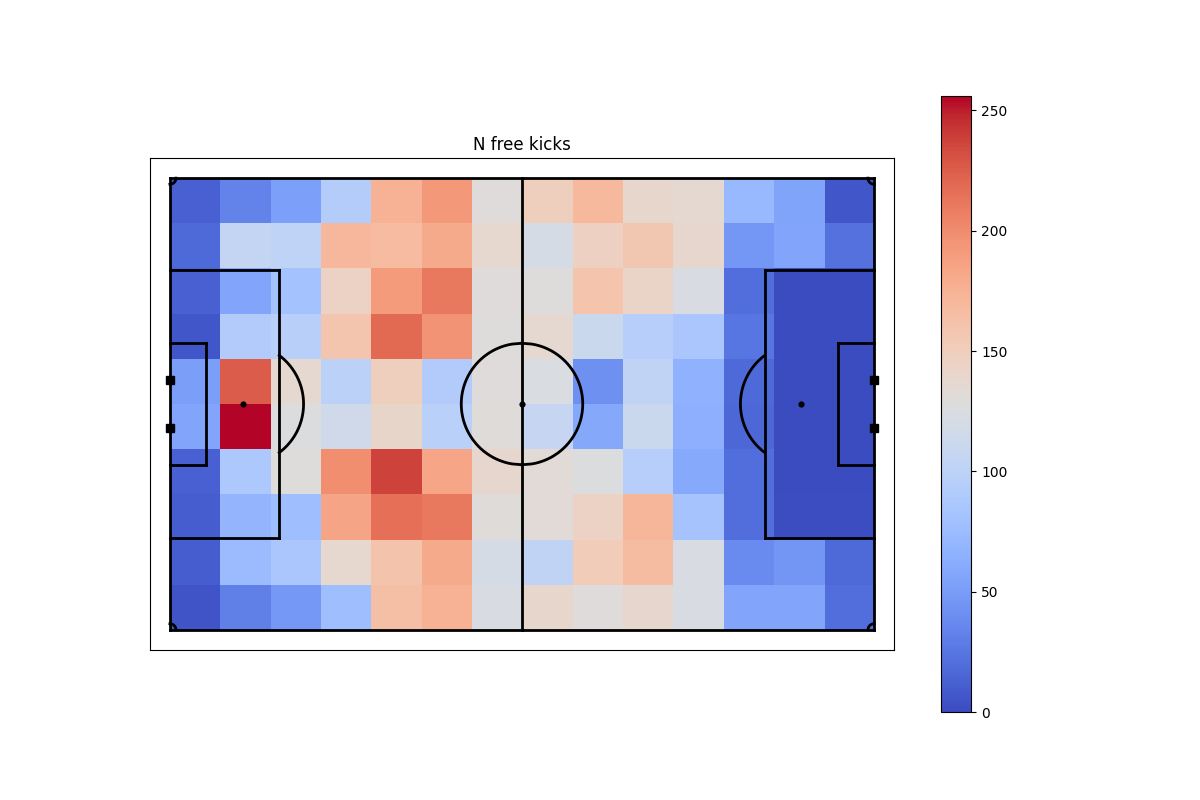

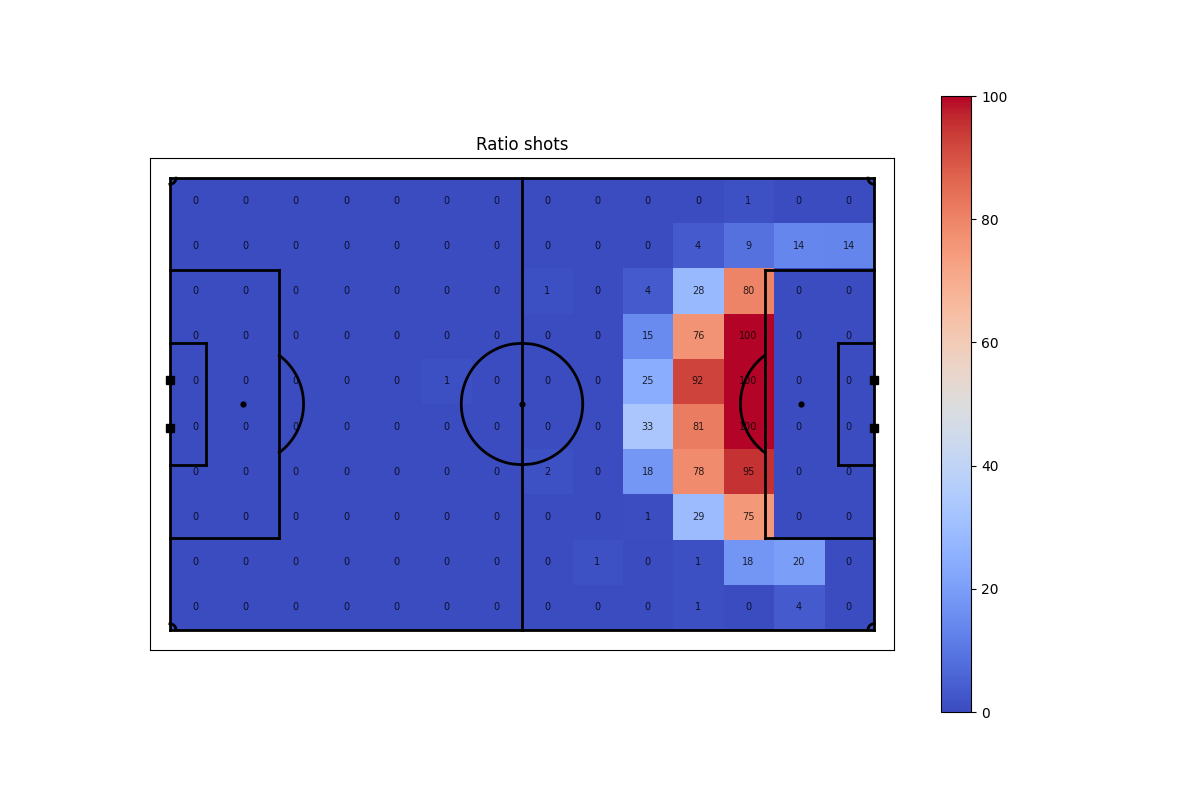

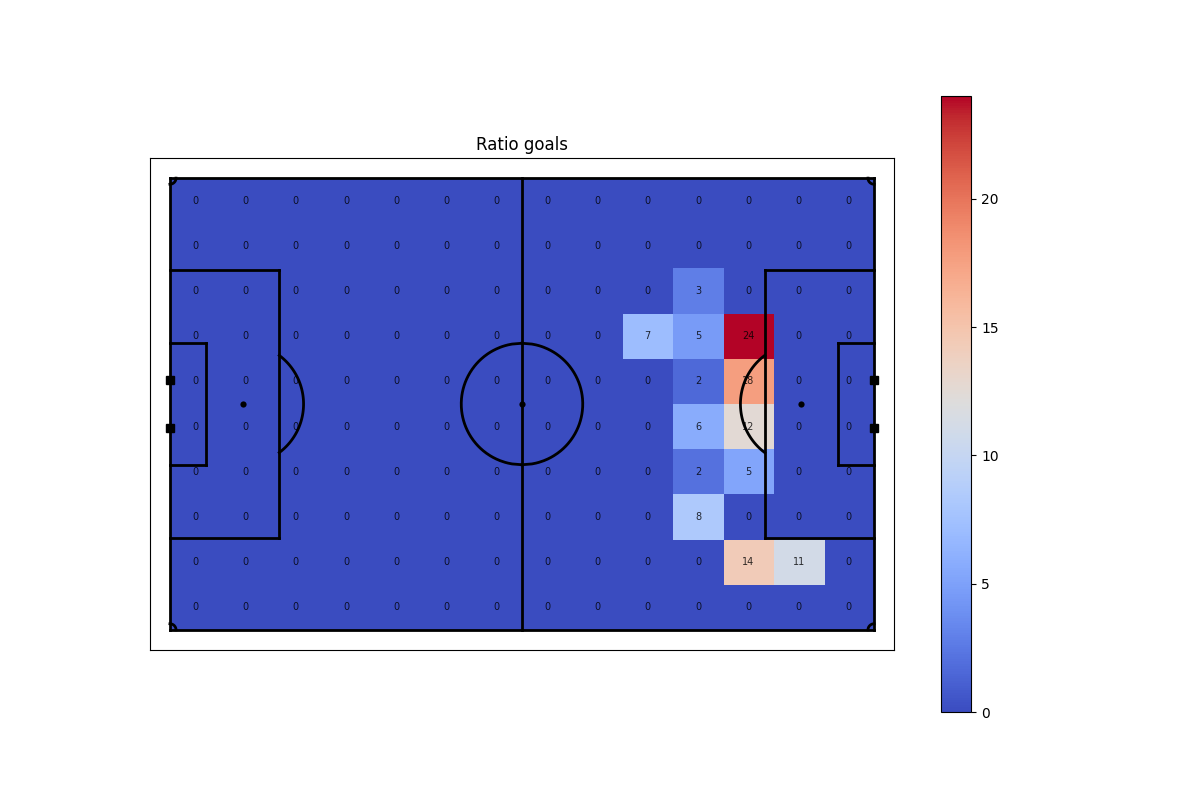

In [ ]:
N_X_BINS = 14
N_Y_BINS = 10
X_RANGE = (-53, 53)
Y_RANGE = (-34, 34)
PITCH_LENGTH = 106
PITCH_WIDTH = 68
CELL_LENGTH = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
CELL_WIDTH = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

hist2d_params = {"bins": (N_X_BINS, N_Y_BINS), "range": [X_RANGE, Y_RANGE]}

hist_events, x_edges, y_edges = np.histogram2d(free_kicks['start_x'], free_kicks['start_y'], **hist2d_params)
hist_shots, _, _ = np.histogram2d(free_kicks.loc[free_kicks["event"]=="shot", 'start_x'], free_kicks.loc[free_kicks["event"]=="shot", 'start_y'], **hist2d_params)
hist_goals, _, _ = np.histogram2d(
    free_kicks.loc[((free_kicks["event"]=="shot") & (free_kicks["successful"]==1)), 'start_x'], 
    free_kicks.loc[((free_kicks["event"]=="shot") & (free_kicks["successful"]==1)), 'start_y'], 
    **hist2d_params
) 
hist_ball_moves, _, _ = np.histogram2d(free_kicks.loc[free_kicks["event"]!="shot", 'start_x'], free_kicks.loc[free_kicks["event"]!="shot", 'start_y'], **hist2d_params)
hist_ball_moves_succ, _, _ = np.histogram2d(
    free_kicks.loc[((free_kicks["event"]!="shot") & (free_kicks["successful"]==1)), 'start_x'], 
    free_kicks.loc[((free_kicks["event"]!="shot") & (free_kicks["successful"]==1)), 'start_y'], 
    **hist2d_params
)
ratio_shots = np.divide(hist_shots, hist_events, where=hist_events!=0)
ratio_goals = np.divide(hist_goals, hist_shots, where=hist_shots!=0)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events!=0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves!=0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

plot_results(hist_events.ravel()/100., title="N free kicks", add_text=False, )
plot_results(ratio_shots.ravel(), title="Ratio shots", add_text=True)
plot_results(ratio_goals.ravel(), title="Ratio goals", add_text=True)

In [ ]:
succ_move_probs = np.zeros((N_X_BINS * N_Y_BINS, N_X_BINS * N_Y_BINS))
xg_vals = np.zeros(N_X_BINS * N_Y_BINS)

xg_by_free_kick_params = xg_params["xG_by_free_kick"]
cell_id = 0
for x_start1, x_start2 in zip(x_edges[:-1], x_edges[1:]):
    # df of all events that are within the x range
    start_df_x = free_kicks[((free_kicks["start_x"] >= x_start1) & (free_kicks["start_x"] <= x_start2))]
    for y_start1, y_start2 in zip(y_edges[:-1], y_edges[1:]):
        # df of all events that are within the x and the y range
        start_df = start_df_x[((start_df_x["start_y"] >= y_start1) & (start_df_x["start_y"] <= y_start2))]
        succ_mask = (~start_df["end_x"].isnull()) & (~start_df["end_y"].isnull()) & (start_df["event"]!="shot") & (start_df["successful"]==1)
        hist_ball_moves_succ_current_pos, _, _ = np.histogram2d(start_df.loc[succ_mask, "end_x"], start_df.loc[succ_mask, "end_y"], **hist2d_params)
        if len(start_df) > 0:
            current_ratio = hist_ball_moves_succ_current_pos / len(start_df)
        else:
            current_ratio = np.zeros(hist_ball_moves_succ_current_pos.shape)
        succ_move_probs[cell_id] = current_ratio.ravel()

        # Fill xG array
        loc = np.array([np.mean([x_start1, x_start2]), np.mean([y_start1, y_start2])])
        goal_distance = np.sqrt(np.power(X_RANGE[1] - loc[0], 2) + np.power(loc[1], 2))
        shot_angle = get_smallest_angle(loc - np.array([X_RANGE[1], 3.63]), loc - np.array([X_RANGE[1], -3.66]), angle_format="degree")
        xg_vals[cell_id] = scale_and_predict_logreg(np.array([[goal_distance, shot_angle]]), xg_by_free_kick_params)[0]

        cell_id += 1     

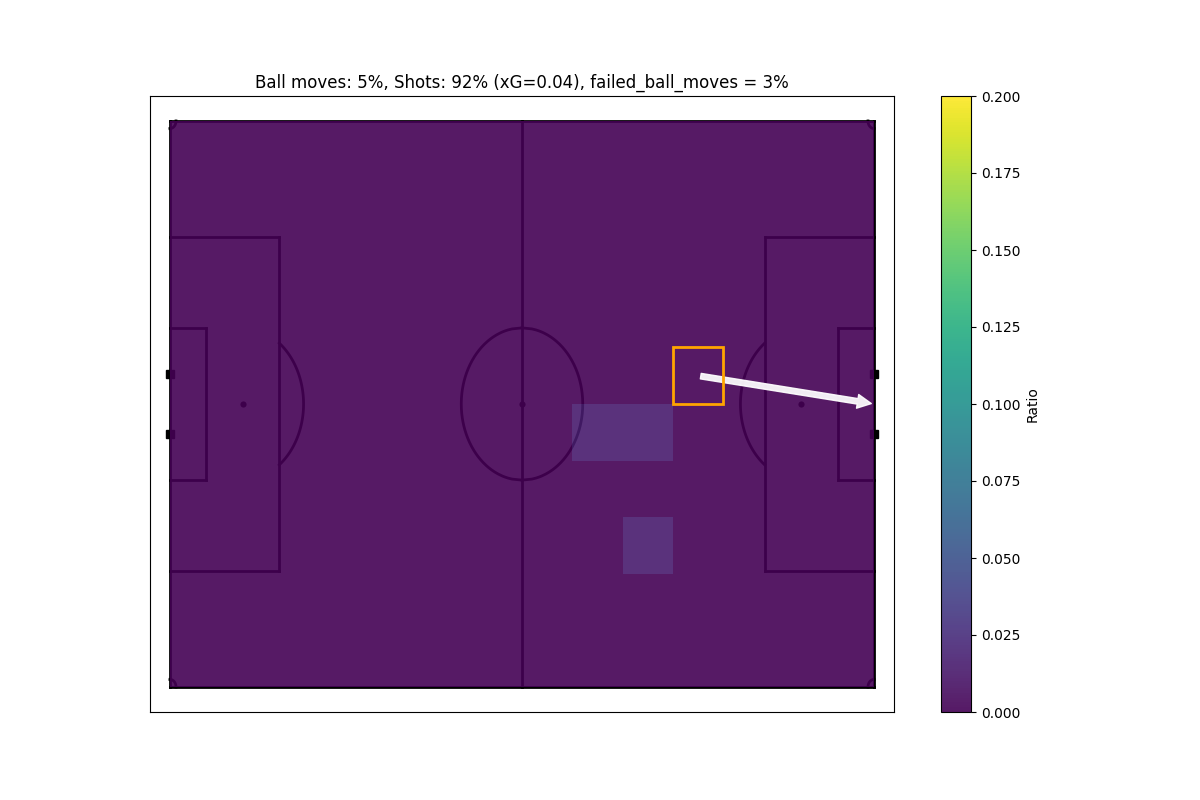

In [ ]:
%matplotlib widget

box_width = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
box_height = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

idx = int(N_Y_BINS * (N_X_BINS - int(0.3*N_X_BINS)) + (0.5 * N_Y_BINS))
x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height

plt.close("all")
fig, ax = plot_soccer_pitch(pitch_color="white")
ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
fig.colorbar(pcm, ax=ax, label="Ratio")

goal_loc = (53.0, 0)
arrow = mpatches.FancyArrowPatch((x1 + 0.5 * box_width, y1 + 0.5 * box_height), goal_loc,
                                 mutation_scale=20)
arrow.set_alpha(ratio_shots.ravel()[idx])
arrow.set_color("white")
ax.add_patch(arrow)

ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
ratio_shot = int(ratio_shots.ravel()[idx] *100)
xg = round(xg_vals[idx], 2)
ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)

ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
ax.add_patch(rec)
fig.canvas.draw_idle()


pitch_size = (X_RANGE[1] - X_RANGE[0], Y_RANGE[1] - Y_RANGE[0])
add_mirrored_index = False
def on_click(event):
    if event.inaxes == ax:

        [col.remove() for col in ax.collections]
        [patch.remove() for patch in ax.patches]
        [text.remove() for text in ax.texts]
        
        x = event.xdata
        y = event.ydata
        x_idx = np.floor((x + X_RANGE[1]) / (pitch_size[0] / N_X_BINS))
        y_idx = np.floor((y + Y_RANGE[1]) / (pitch_size[1] / N_Y_BINS))
        idx = int(x_idx * N_Y_BINS + y_idx)
        ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
        pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
        
        x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
        y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height
        rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
        ax.add_patch(rec)

        if add_mirrored_index:
            mirrored_index = get_mirrored_index(idx)
            x2 = X_RANGE[0] + (mirrored_index // N_Y_BINS) * box_width
            y2 = Y_RANGE[0] + (mirrored_index % N_Y_BINS) * box_height
            rec = Rectangle((x2, y2), width=box_width, height=box_height, color='red', fc='none', lw=2)
            ax.add_patch(rec)
        
        ax.scatter([x], [y], color="black")
        
        arrow = mpatches.FancyArrowPatch((x , y), goal_loc, mutation_scale = 20)
        arrow.set_alpha(ratio_shots.ravel()[idx])
        arrow.set_color("white")
        ax.add_patch(arrow)
        
        ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
        ratio_shot = int(ratio_shots.ravel()[idx] *100)
        xg = round(xg_vals[idx], 2)
        ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)
        
        ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
        ax.axes()
            

        fig.canvas.draw_idle()
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

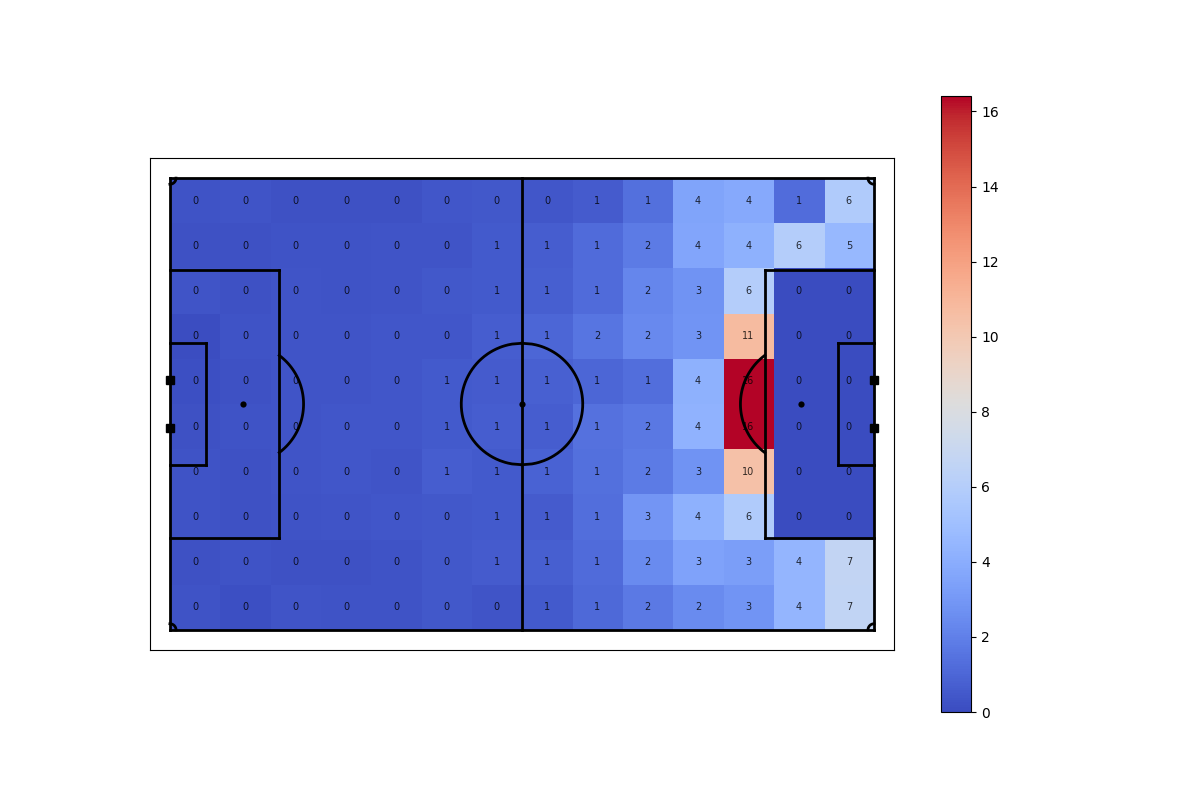

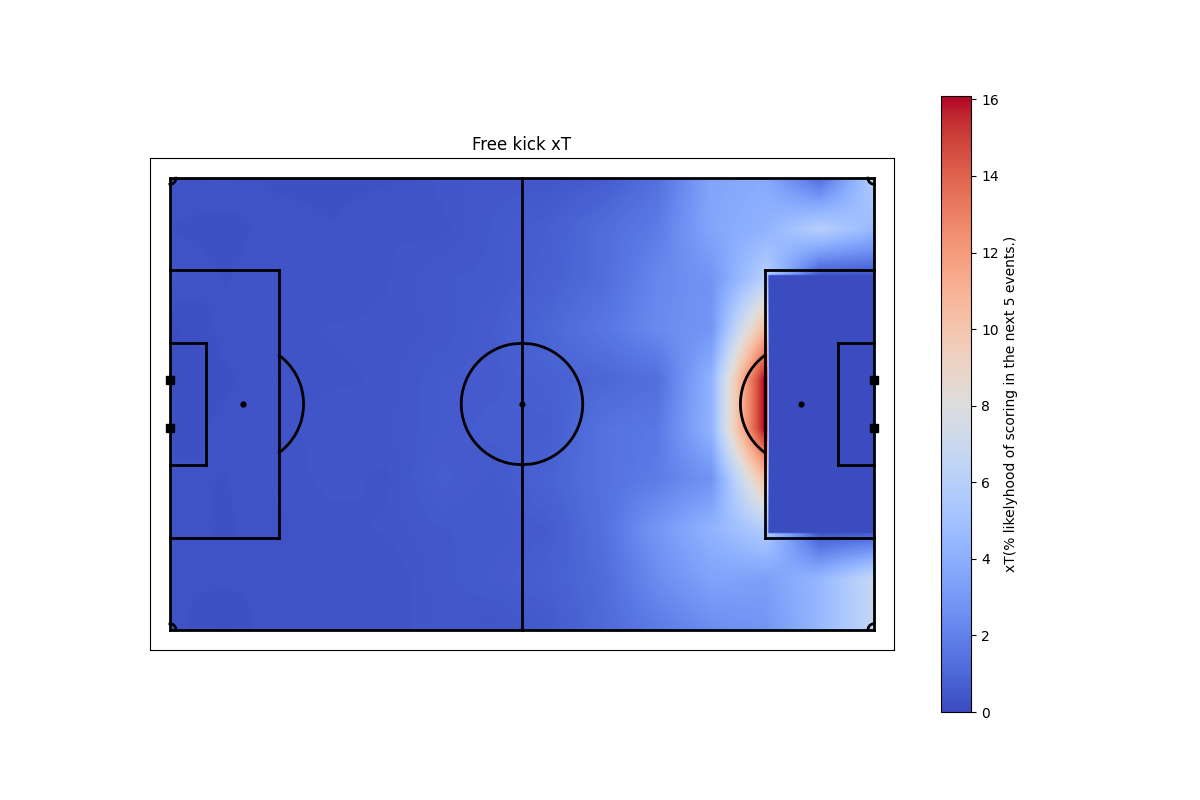

In [ ]:
plt.close("all")

free_kick_xT = np.zeros(N_X_BINS * N_Y_BINS)
open_play_xT_grid = np.zeros(N_X_BINS * N_Y_BINS)

for cell in range(len(open_play_xT_grid)):
    x = (cell // N_Y_BINS + 0.5) * CELL_LENGTH - 53
    y = (cell % N_Y_BINS + 0.5) * CELL_WIDTH - 34
    open_play_xT_grid[cell] = get_xT_prediction(x, y)

# Loop over all possible location where you can have the ball
for current_cell_id in range(len(free_kick_xT)):

    # Given the current location, update the xT with the probability of a shot times the xG value of that shot
    current_cell_xT =  xg_vals[current_cell_id] * ratio_shots.ravel()[current_cell_id] 

    # Loop over all possible ball move options, and their likelyhood of happening successfully
    for to_cell_id in range(len(free_kick_xT)):
        x = (to_cell_id // N_Y_BINS + 0.5) * CELL_LENGTH - 53
        y = (to_cell_id % N_Y_BINS + 0.5) * CELL_WIDTH - 34
        

        # Update the xT with the probability of a successful ball move times the xT of that end location in open play
        current_cell_xT += succ_move_probs[current_cell_id, to_cell_id] * open_play_xT_grid[to_cell_id]
    # Save the new xT of the current position
    free_kick_xT[current_cell_id] = current_cell_xT


finegrained_free_kick_xt = zoom(free_kick_xT.reshape(N_X_BINS, N_Y_BINS), [264/N_X_BINS, 196/N_Y_BINS], order=1)
start_box_x_idx = 264 - int(round(264 / 106 * 16.5))
start_box_y_left_idx = int(round(196 / 68 * 14.3))
start_box_y_right_idx = 196 - int(round(196 / 68 * 14.5))
for i in range(finegrained_free_kick_xt.shape[0]):
    if i <= start_box_x_idx:
        continue
    for j in range(finegrained_free_kick_xt.shape[1]):
        if j > start_box_y_left_idx and j < start_box_y_right_idx:
            finegrained_free_kick_xt[i, j] = 0.0

plot_results(free_kick_xT)
plot_results(finegrained_free_kick_xt.ravel(), title="Free kick xT", label="xT(% likelyhood of scoring in the next 5 events.)", n_x_bins_func=264, n_y_bins_func=196, add_text=False)

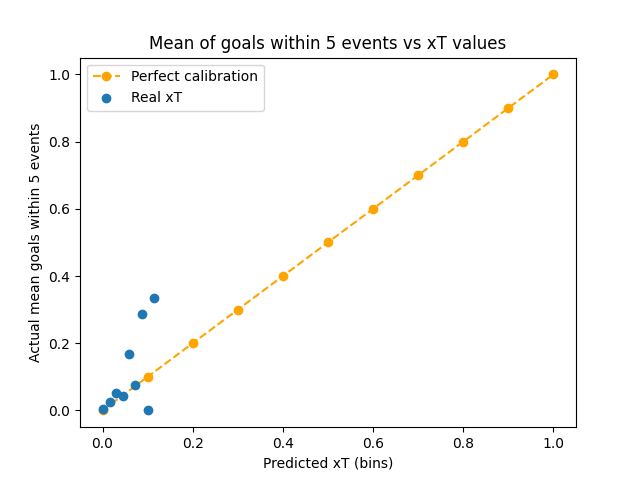

In [ ]:
goal_within_5_events = (free_kicks["n_events_next_goal"] < 5).fillna(0)

x, y = free_kicks["start_x"].values, free_kicks["start_y"].values

xt_values = get_xT_prediction(x, y, finegrained_free_kick_xt)

bins = np.linspace(xt_values.min(), xt_values.max(), 10)
bin_indices = np.digitize(xt_values, bins)
bin_means = [np.nanmean(np.array(goal_within_5_events)[bin_indices == i]) for i in range(1, len(bins))]
plt.close("all")
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), marker="o", label="Perfect calibration", linestyle='--', color="orange", zorder=-1)
ax.scatter(bins[:-1], np.array(bin_means), label="Real xT")
ax.set_xlabel('Predicted xT (bins)')
ax.set_ylabel('Actual mean goals within 5 events')
ax.set_title('Mean of goals within 5 events vs xT values')
ax.legend()
plt.show()

In [ ]:
np.save("../../databallpy/models/free_kick_xT.npy", finegrained_free_kick_xt)

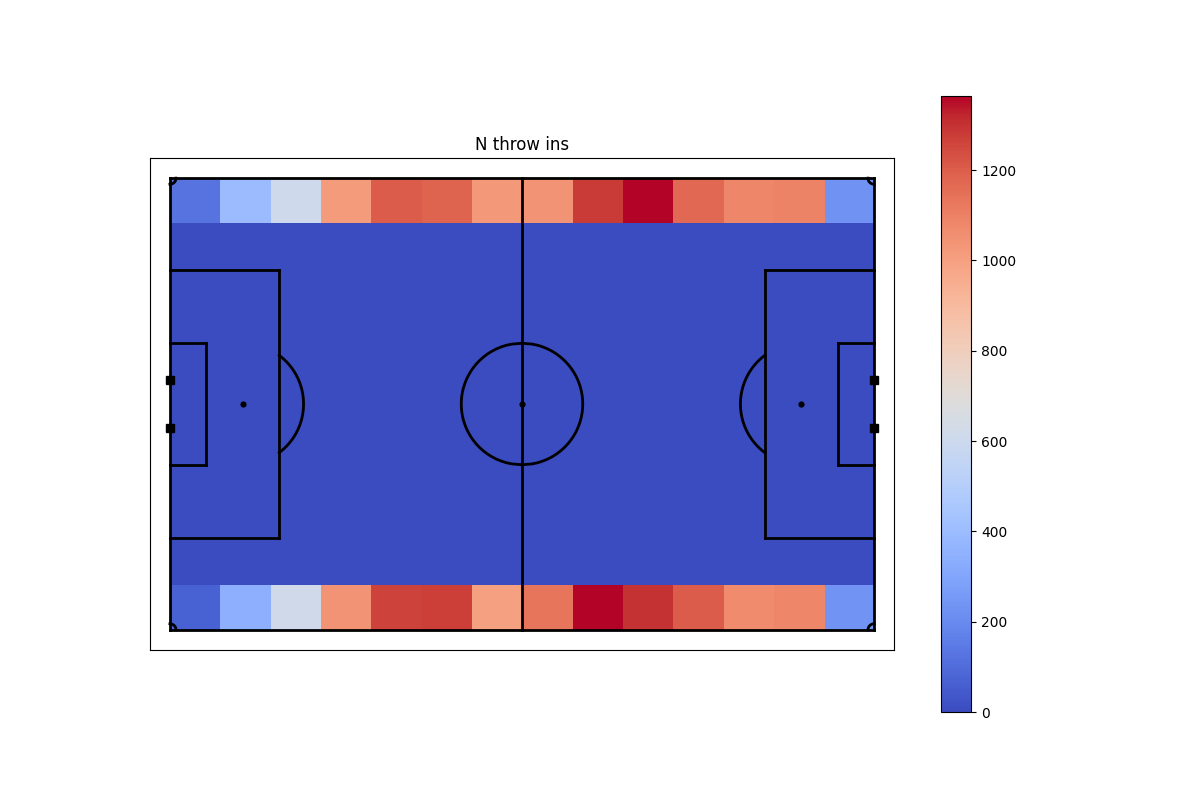

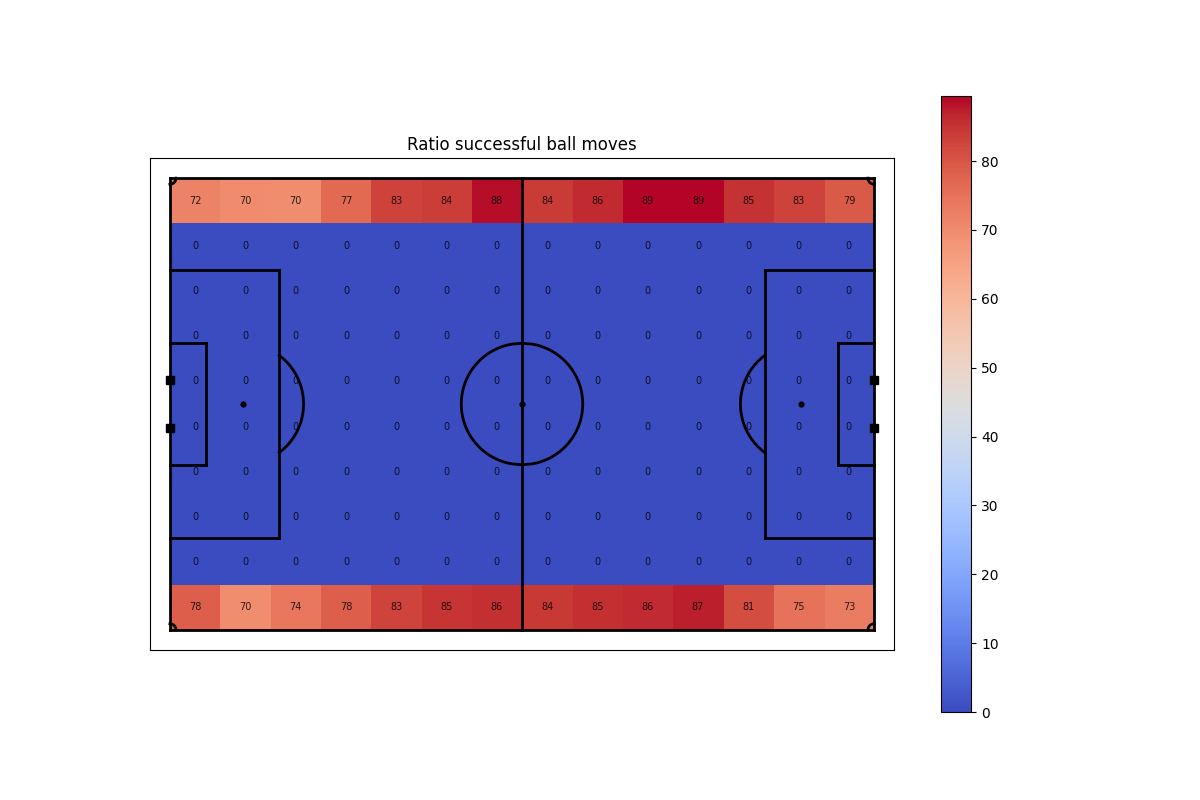

In [ ]:
N_X_BINS = 14
N_Y_BINS = 10
X_RANGE = (-53, 53)
Y_RANGE = (-34, 34)
PITCH_LENGTH = 106
PITCH_WIDTH = 68
CELL_LENGTH = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
CELL_WIDTH = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

hist2d_params = {"bins": (N_X_BINS, N_Y_BINS), "range": [X_RANGE, Y_RANGE]}

hist_events, x_edges, y_edges = np.histogram2d(throw_ins['start_x'], throw_ins['start_y'], **hist2d_params)
hist_shots, _, _ = np.histogram2d(throw_ins.loc[throw_ins["event"]=="shot", 'start_x'], throw_ins.loc[throw_ins["event"]=="shot", 'start_y'], **hist2d_params)
hist_goals, _, _ = np.histogram2d(
    throw_ins.loc[((throw_ins["event"]=="shot") & (throw_ins["successful"]==1)), 'start_x'], 
    throw_ins.loc[((throw_ins["event"]=="shot") & (throw_ins["successful"]==1)), 'start_y'], 
    **hist2d_params
) 
hist_ball_moves, _, _ = np.histogram2d(throw_ins.loc[throw_ins["event"]!="shot", 'start_x'], throw_ins.loc[throw_ins["event"]!="shot", 'start_y'], **hist2d_params)
hist_ball_moves_succ, _, _ = np.histogram2d(
    throw_ins.loc[((throw_ins["event"]!="shot") & (throw_ins["successful"]==1)), 'start_x'], 
    throw_ins.loc[((throw_ins["event"]!="shot") & (throw_ins["successful"]==1)), 'start_y'], 
    **hist2d_params
)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events!=0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves!=0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

plot_results(hist_events.ravel()/100., title="N throw ins", add_text=False, )
plot_results(ratio_ball_moves_succ.ravel(), title="Ratio successful ball moves", add_text=True)

In [ ]:
succ_move_probs = np.zeros((N_X_BINS * N_Y_BINS, N_X_BINS * N_Y_BINS))
xg_vals = np.zeros(N_X_BINS * N_Y_BINS)

cell_id = 0
for x_start1, x_start2 in zip(x_edges[:-1], x_edges[1:]):
    # df of all events that are within the x range
    start_df_x = throw_ins[((throw_ins["start_x"] >= x_start1) & (throw_ins["start_x"] <= x_start2))]
    for y_start1, y_start2 in zip(y_edges[:-1], y_edges[1:]):
        # df of all events that are within the x and the y range
        start_df = start_df_x[((start_df_x["start_y"] >= y_start1) & (start_df_x["start_y"] <= y_start2))]
        succ_mask = (~start_df["end_x"].isnull()) & (~start_df["end_y"].isnull()) & (start_df["event"]!="shot") & (start_df["successful"]==1)
        hist_ball_moves_succ_current_pos, _, _ = np.histogram2d(start_df.loc[succ_mask, "end_x"], start_df.loc[succ_mask, "end_y"], **hist2d_params)
        if len(start_df) > 0:
            current_ratio = hist_ball_moves_succ_current_pos / len(start_df)
        else:
            current_ratio = np.zeros(hist_ball_moves_succ_current_pos.shape)
        succ_move_probs[cell_id] = current_ratio.ravel()
        
        cell_id += 1   

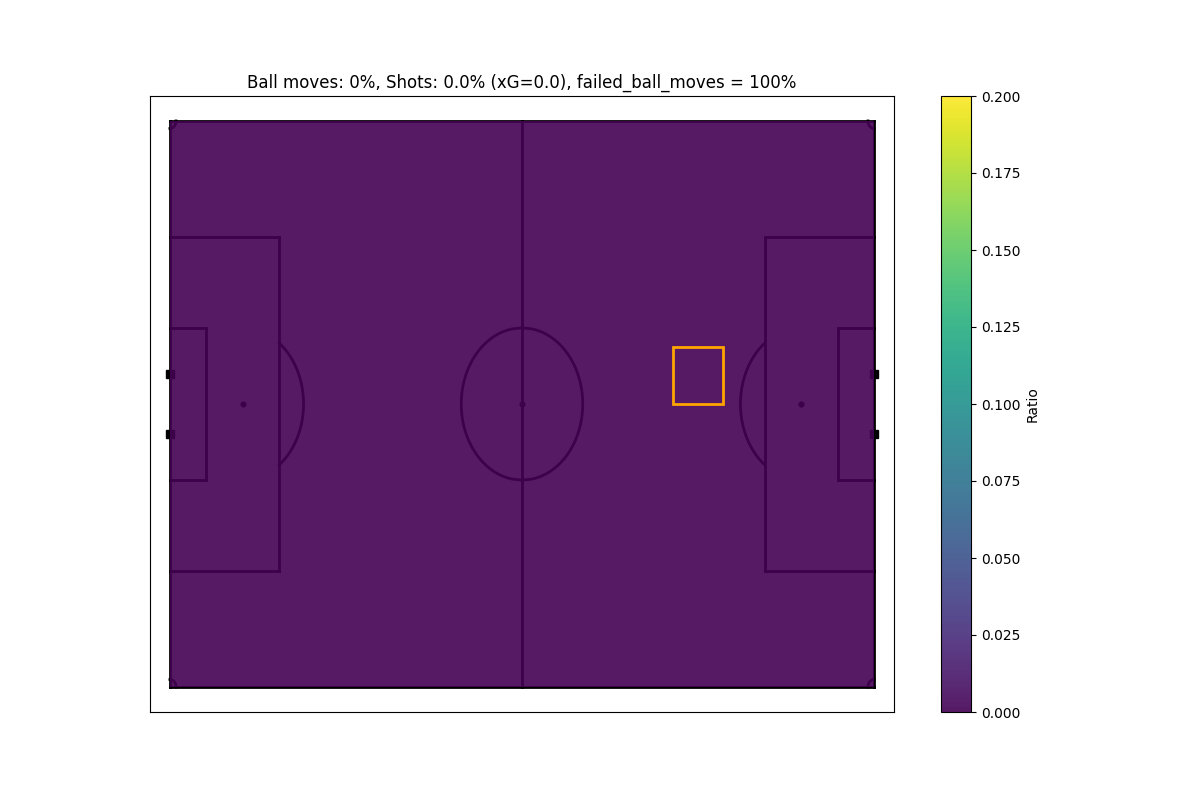

In [ ]:
%matplotlib widget

box_width = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
box_height = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

idx = int(N_Y_BINS * (N_X_BINS - int(0.3*N_X_BINS)) + (0.5 * N_Y_BINS))
x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height

plt.close("all")
fig, ax = plot_soccer_pitch(pitch_color="white")
ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
fig.colorbar(pcm, ax=ax, label="Ratio")

ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
ratio_failed_ball_move = (100 - ratio_suc_ball_move_per)

ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: 0.0% (xG={0.0}), failed_ball_moves = {ratio_failed_ball_move}%")
rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
ax.add_patch(rec)
fig.canvas.draw_idle()


pitch_size = (X_RANGE[1] - X_RANGE[0], Y_RANGE[1] - Y_RANGE[0])
add_mirrored_index = False
def on_click(event):
    if event.inaxes == ax:

        [col.remove() for col in ax.collections]
        [patch.remove() for patch in ax.patches]
        [text.remove() for text in ax.texts]
        
        x = event.xdata
        y = event.ydata
        x_idx = np.floor((x + X_RANGE[1]) / (pitch_size[0] / N_X_BINS))
        y_idx = np.floor((y + Y_RANGE[1]) / (pitch_size[1] / N_Y_BINS))
        idx = int(x_idx * N_Y_BINS + y_idx)
        ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
        pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.2)
        
        x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
        y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height
        rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
        ax.add_patch(rec)

        if add_mirrored_index:
            mirrored_index = get_mirrored_index(idx)
            x2 = X_RANGE[0] + (mirrored_index // N_Y_BINS) * box_width
            y2 = Y_RANGE[0] + (mirrored_index % N_Y_BINS) * box_height
            rec = Rectangle((x2, y2), width=box_width, height=box_height, color='red', fc='none', lw=2)
            ax.add_patch(rec)
        
        ax.scatter([x], [y], color="black")
        
        arrow = mpatches.FancyArrowPatch((x , y), goal_loc, mutation_scale = 20)
        arrow.set_alpha(ratio_shots.ravel()[idx])
        arrow.set_color("white")
        ax.add_patch(arrow)
        
        ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
        ratio_failed_ball_move = (100 - ratio_suc_ball_move_per)
        
        ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {0.0}% (xG={0.0}), failed_ball_moves = {ratio_failed_ball_move}%")
        ax.axes()
            

        fig.canvas.draw_idle()
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

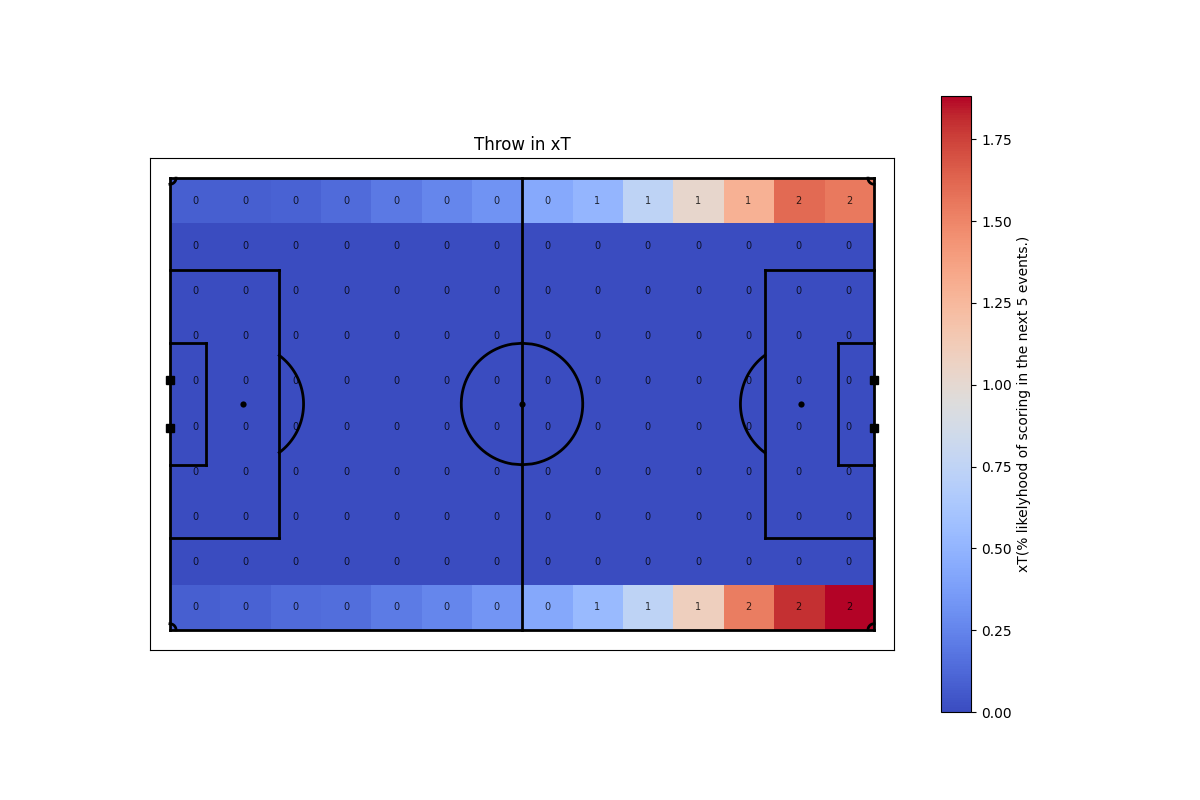

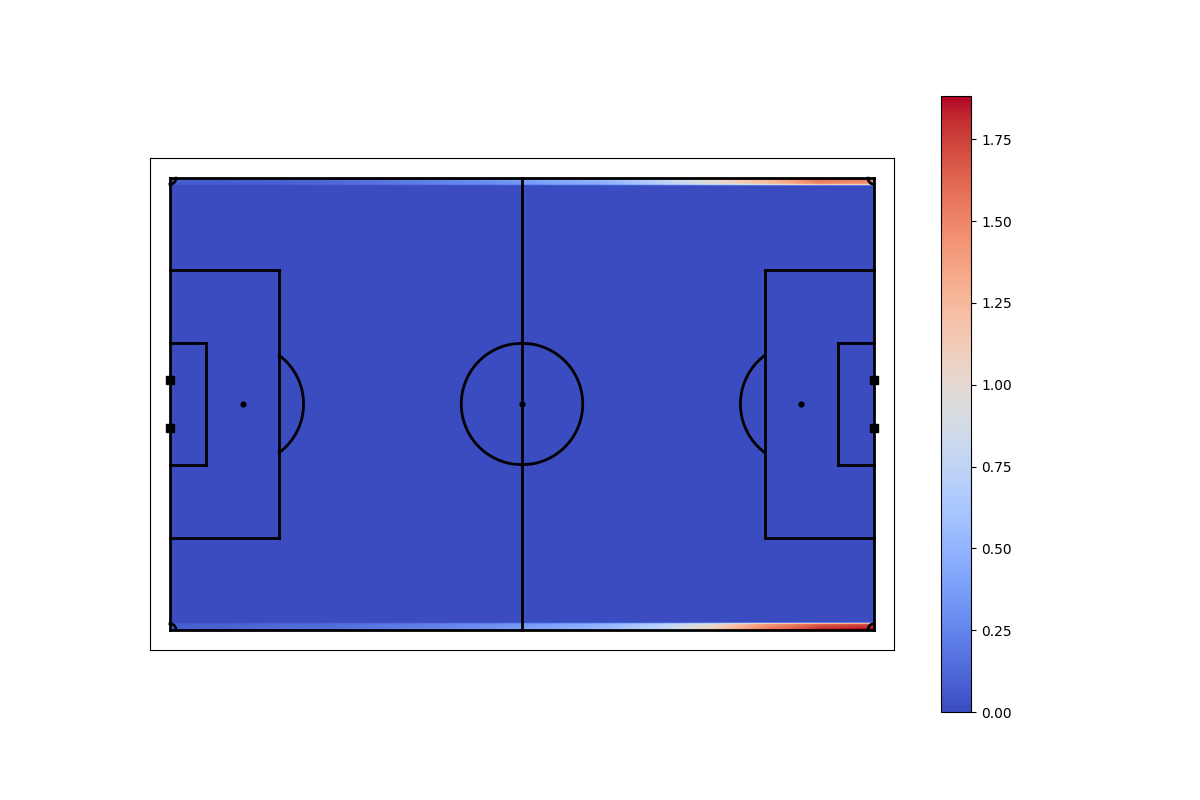

In [ ]:
plt.close("all")

throw_in_xT = np.zeros(N_X_BINS * N_Y_BINS)
open_play_xT_grid = np.zeros(N_X_BINS * N_Y_BINS)
for cell in range(len(open_play_xT_grid)):
    x = (cell // N_Y_BINS + 0.5) * CELL_LENGTH - 53
    y = (cell % N_Y_BINS + 0.5) * CELL_WIDTH - 34
    open_play_xT_grid[cell] = get_xT_prediction(x, y)

# Loop over all possible location where you can have the ball
for current_cell_id in range(len(throw_in_xT)):

    # throw ins are never shots or goals
    current_cell_xT =  0

    # Loop over all possible ball move options, and their likelyhood of happening successfully
    for to_cell_id in range(len(throw_in_xT)):
        x = (to_cell_id // N_Y_BINS + 0.5) * CELL_LENGTH - 53
        y = (to_cell_id % N_Y_BINS + 0.5) * CELL_WIDTH - 34
        

        # Update the xT with the probability of a successful ball move times the xT of that end location in open play
        current_cell_xT += succ_move_probs[current_cell_id, to_cell_id] * get_xT_prediction(x, y)
    # Save the new xT of the current position
    throw_in_xT[current_cell_id] = current_cell_xT
    
finegrained_throw_in_xt = zoom(throw_in_xT.reshape(N_X_BINS, N_Y_BINS), [264/N_X_BINS, 196/N_Y_BINS], order=1)
finegrained_throw_in_xt[:, 3:-3] = 0.0
plot_results(throw_in_xT, title="Throw in xT", label="xT(% likelyhood of scoring in the next 5 events.)" )
plot_results(finegrained_throw_in_xt.ravel(), n_x_bins_func=264, n_y_bins_func=196, add_text=False)

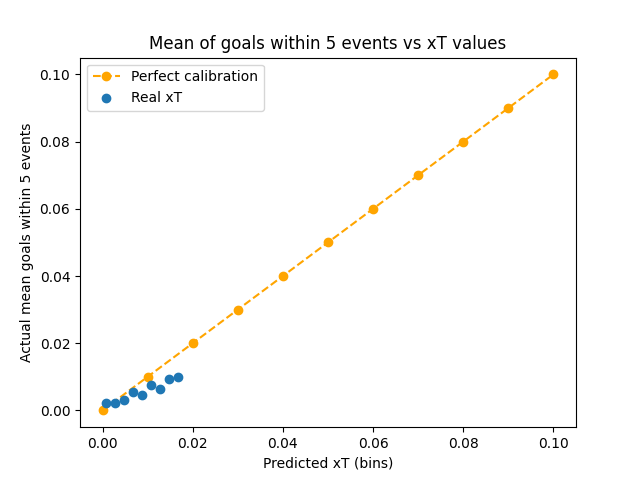

In [ ]:
goal_within_5_events = (throw_ins["n_events_next_goal"] < 5).fillna(0)

x, y = throw_ins["start_x"].values, throw_ins["start_y"].values

xt_values = get_xT_prediction(x, y, finegrained_throw_in_xt)

bins = np.linspace(xt_values.min(), xt_values.max(), 10)
bin_indices = np.digitize(xt_values, bins)
bin_means = [np.nanmean(np.array(goal_within_5_events)[bin_indices == i]) for i in range(1, len(bins))]
plt.close("all")
fig, ax = plt.subplots()

ax.plot(np.linspace(0, .1, 11), np.linspace(0, .1, 11), marker="o", label="Perfect calibration", linestyle='--', color="orange", zorder=-1)
ax.scatter(bins[:-1], np.array(bin_means), label="Real xT")
ax.set_xlabel('Predicted xT (bins)')
ax.set_ylabel('Actual mean goals within 5 events')
ax.set_title('Mean of goals within 5 events vs xT values')
ax.legend()
plt.show()

In [ ]:
np.save("../../databallpy/models/throw_in_xT.npy", finegrained_throw_in_xt)